[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aoguedao/math685_numerical_analysis/blob/main/assigments/hwk03.ipynb)

# MATH685 - Homework #03

_Alonso Ogueda_

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Exercise 2

In [2]:
def p3(x):

    x0, x1, x2 = 0, np.pi / 8, np.pi / 4
    y0 = 1
    y01 = (np.sqrt(2 + np.sqrt(2)) - 2) / (np.pi / 4)
    y012 = (np.sqrt(2) - 2 * np.sqrt(2 + np.sqrt(2)) + 2) / ((np.pi / 4) ** 2)
    y0123 = 2 ** 7 / (3 * np.pi * 3) * (-2 -3 * np.sqrt(2) + 3 * np.sqrt(2 + np.sqrt(2)) + np.sqrt(2 - np.sqrt(2)))
    values = y0 + (x - x0) * y01 + (x - x0) * (x - x1) * y012 + (x - x0) * (x - x1) * (x - x2) * y0123
    return values

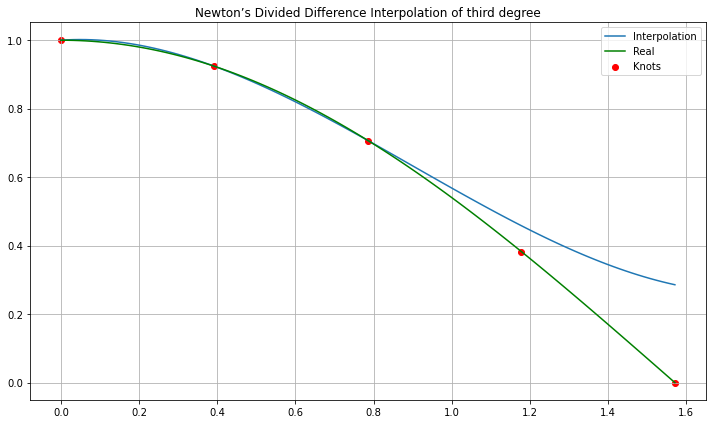

In [3]:
x_knots = np.array([0, np.pi / 8, np.pi / 4, 3 * np.pi / 8, np.pi / 2])
y_knots = np.cos(x_knots)
x_array = np.linspace(0, np.pi / 2, 100)
y_array = p3(x_array)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_array, y_array, label="Interpolation")
ax.plot(x_array, np.cos(x_array), color="green", label="Real")
ax.scatter(x_knots, y_knots, color="r", label="Knots")
ax.grid()
ax.legend()
ax.set_title("Newton’s Divided Difference Interpolation of third degree")
fig.tight_layout()
plt.savefig("images/hwk03/exercise02.png", dpi=300)
fig.show()

## Exercise 5

In [26]:
x = np.array([0, 0.25, 0.5, 0.75, 1])
y = np.array([1, 1.2840, 1.6487, 2.1170, 2.7183])

In [27]:
df5 = (
    pd.DataFrame({"xi": x, "yi": y})
    .assign(
        xi2=lambda x: x["xi"] ** 2,
        xi3=lambda x: x["xi"] ** 3,
        xi4=lambda x: x["xi"] ** 4,
        yixi=lambda x: x["yi"] * x["xi"],
        yixi2=lambda x: x["yi"] * x["xi2"],
    )
)

In [28]:
sums5 = df5.sum()
X = np.array(
    [
        [len(x), sums5["xi"], sums5["xi2"]],
        [sums5["xi"], sums5["xi2"], sums5["xi3"]],
        [sums5["xi2"], sums5["xi3"], sums5["xi4"]]
    ]
)
b = np.array([sums5["yi"], sums5["yixi"], sums5["yixi2"]])
coefs = np.linalg.solve(X, b)

In [35]:
error = np.sum((coefs[2] * x ** 2 + coefs[1] * x + coefs[0] - y) ** 2)
error

0.00027413257142858106

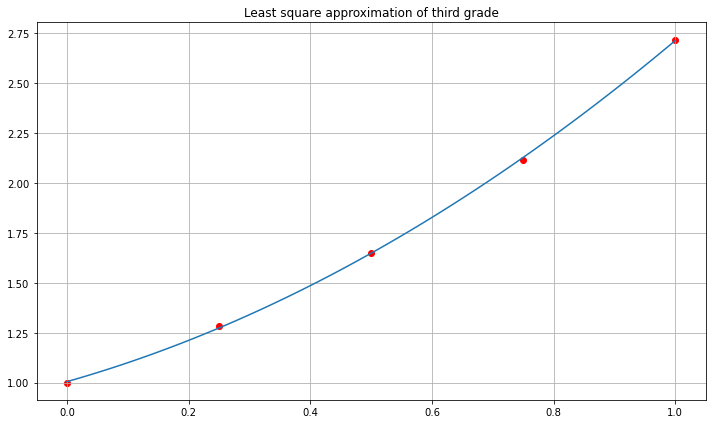

In [36]:
x_array = np.linspace(min(x), max(x), 100)
ls_values = coefs[2] * x_array ** 2 + coefs[1] * x_array + coefs[0]
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_array, ls_values)
ax.scatter(x, y, color="r")
ax.grid()
ax.set_title("Least square approximation of third grade")
fig.tight_layout()
plt.savefig("images/hwk03/exercise05.png", dpi=300)
fig.show()

## Exercise 6

In [8]:
def spline_coefficients(x_knots, y_knots, dy0, dyn):

    # Tridiagonal matrix
    h = np.ediff1d(x_knots)
    mu = np.array([i / (i + j) for i, j in zip(h[:-1], h[1:])])
    lam = 1 - mu
    mu = np.append(mu, 1)
    lam = np.append(1, lam)
    A = 2 * np.identity(len(x_knots)) + np.diagflat(lam, k = 1) + np.diagflat(mu, k = -1)

    # Function values
    d = []
    for i in range(1, len(x_knots) - 1):
        f01 = (y_knots[i] - y_knots[i - 1]) / (x_knots[i] - x_knots[i - 1])
        f12 = (y_knots[i + 1] - y_knots[i]) / (x_knots[i + 1] - x_knots[i])
        f012 = (f12 - f01) / (x_knots[i + 1] - x_knots[i - 1])
        d.append(f012)
    d = 6 * np.array(d)
    d0 = 6 / h[0] * ((y_knots[1] - y_knots[0]) / (x_knots[1] - x_knots[0]) - dy0 )
    dn = 6 / h[-1] * ( dyn - (y_knots[-1] - y_knots[-2]) / (x_knots[-1] - x_knots[-2]) )
    d = np.hstack([d0, d, dn])

    # Coefficients
    z = np.linalg.solve(A, d)
    return z

In [9]:
def spline_interval(x, x1, x2, y1, y2, z1, z2, h):
    x = np.asarray(x)
    s = (
        np.power((x2 - x), 3) * z1 / (6 * h)
        + np.power((x - x1), 3) * z2 / (6 * h)
        + (y1 - (z1 * h ** 2) / 6) * (x2 - x) / h
        + (y2 - (z2 * h ** 2) / 6) * (x - x1) / h
    )
    return s

In [10]:
def spline_values(x_knots, y_knots, dy0, dyn):

    spline_coefs = spline_coefficients(x_knots, y_knots, dy0, dyn)

    x_array = []
    values = []
    h = np.ediff1d(x_knots)
    for i in range(1, len(x_knots)):
        x_array_i = np.linspace(x_knots[i - 1], x_knots[i], 100)
        values_i = spline_interval(
            x=x_array_i,
            x1=x_knots[i - 1],
            x2=x_knots[i],
            y1=y_knots[i - 1],
            y2=y_knots[i],
            z1=spline_coefs[i - 1],
            z2=spline_coefs[i],
            h=h[i-1]
        )
        x_array.append(x_array_i)
        values.append(values_i)
    x_array = np.hstack(x_array)
    values = np.hstack(values)
    return spline_coefs, x_array, values

In [11]:
xa = np.array([1, 2, 5, 6, 7, 8, 10, 13, 17])
ya = np.array([3.0, 3.7, 3.9, 4.2, 5.7, 6.6, 7.1, 6.7, 4.5])
dya0 = 1.0
dyan = -0.667

In [12]:
xb = np.array([17, 20, 23, 24, 25, 27, 27.7])
yb = np.array([4.5, 7.0, 6.1, 5.6, 5.8, 5.2, 4.1])
dyb0 = 3.0
dybn = -4.0

In [13]:
xc = np.array([27.7, 28, 29, 30])
yc = np.array([4.1, 4.3, 4.1, 3.0])
dyc0 = 0.33
dycn = -1.5

In [14]:
coefs_a, x_array_a, values_a = spline_values(xa, ya, dya0, dyan)
coefs_b, x_array_b, values_b = spline_values(xb, yb, dyb0, dybn)
coefs_c, x_array_c, values_c = spline_values(xc, yc, dyc0, dycn)

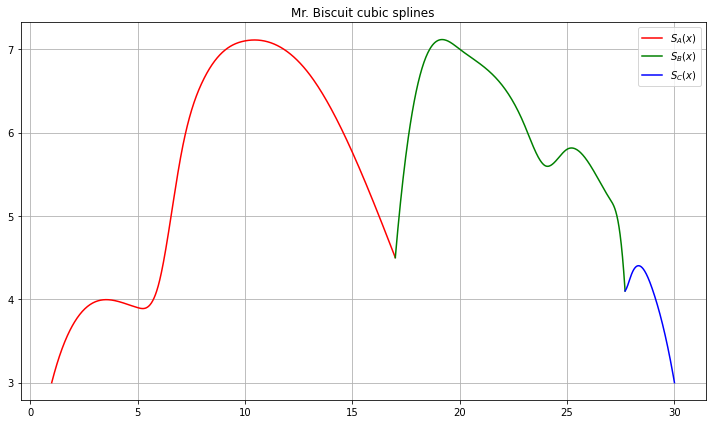

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_array_a, values_a, color="red", label=r"$S_A(x)$")
ax.plot(x_array_b, values_b, color="green", label=r"$S_B(x)$")
ax.plot(x_array_c, values_c, color="blue", label=r"$S_C(x)$")
ax.set_title("Mr. Biscuit cubic splines")
ax.grid()
ax.legend()
fig.tight_layout()
plt.savefig("images/hwk03/exercise06.png", dpi=300)
fig.show()

## Question 7

In [16]:
x_knots = np.array([-1.0, -0.6, -0.2, 0.2, 0.6, 1.0])
y_knots = np.array([-1.0, -0.6, -0.2, 0.2, 0.6, 1.0])
data = pd.DataFrame(
    [
        [-0.1353, -0.1540, -0.0707, 0.0707, 0.1540, 0.1353],
        [-0.2567, -0.2921, -0.1341, 0.1341, 0.2921, 0.2567],
        [-0.3535, -0.4022, -0.1846, 0.1846, 0.4022, 0.3535],
        [-0.3535, -0.4022, -0.1846, 0.1846, 0.4022, 0.3535],
        [-0.2567, -0.2921, -0.1341, 0.1341, 0.2921, 0.2567],
        [-0.1353, -0.1540, -0.0707, 0.0707, 0.1540, 0.1353]
    ],
    index=y_knots,
    columns=x_knots
)

In [17]:
def bilinear_interpolation(x, y, x_knots, y_knots):
    
    x1 = x_knots[x >= x_knots].max()
    x2 = x_knots[x <= x_knots].min()
    y1 = y_knots[y >= y_knots].max()
    y2 = y_knots[y <= y_knots].min()

    q11 = data.loc[y1, x1]
    q12 = data.loc[y2, x1]
    q21 = data.loc[y1, x2]
    q22 = data.loc[y2, x2]

    if (x in x_knots) and (y in y_knots):
        fxy = data.loc[y, x]
    elif (x not in x_knots) and (y in y_knots):
        if y == y1:
            k1, k2 = q11, q21
        elif y == y2:
            k1, k2 = q12, q22
        fxy = ((x2 - x) * k1 + (x - x1) * k2) / (x2 - x1) 
    elif (x in x_knots) and (y not in y_knots):
        if x == x1:
            k1, k2 = q11, q12
        elif x == x2:
            k1, k2 = q21, q22
        fxy = ((y2 - y) * k1 + (y - y1) * k2) / (y2 - y1) 
    else:
        Q = np.array([[q11, q12], [q21, q22]])
        fxy = (
            np.array([x2 - x, x - x1], ndmin=2)
            @
            Q
            @ np.array([y2 - y, y - y1], ndmin=2).T
            / (x2 - x1)
            / (y2 - y1)
        )
        fxy = fxy.item()

    return fxy 

In [18]:
values = []
for x in np.around(np.linspace(-1, 1, 101), decimals=2):
    for y in np.around(np.linspace(-1, 1, 101), decimals=2):
        fxy = bilinear_interpolation(x, y, x_knots, y_knots)
        values.append([x, y, fxy])
bilinear_df = pd.DataFrame(values, columns=["x", "y", "f"])

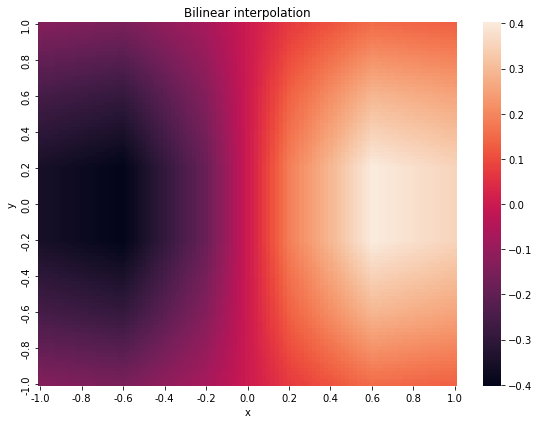

In [19]:
bilinear_pivot = (
    bilinear_df.pivot("y", "x", "f")
    .sort_index(ascending=False)
)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    bilinear_pivot,
    xticklabels=10,
    yticklabels=10,
    ax=ax,
)
ax.set_title("Bilinear interpolation")
fig.tight_layout()
plt.savefig("images/hwk03/exercise07.png", dpi=300)
fig.show()